## Gene set analysis of breast cancer

Train accuracy 0.9656786271450858
Valid accuracy 0.7327272727272728
Test  accuracy 0.885558583106267
Train ROC AUC 0.9961387184007685
Valid ROC AUC 0.7721142614420728
Test  ROC AUC 0.932375581811672


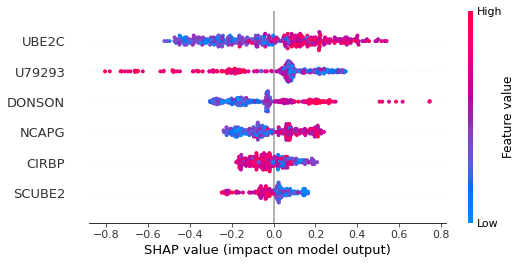

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from deepshap.data import load_gene_expr
from gene_set import load_gene_set, get_beta, get_pathway_attr
from model import xgb_gene

# Import local version of shap
sys.path = ["/homes/gws/hughchen/deepshap-exploration/shap"] + sys.path 
import shap

# Outcome of interest
outcome_name = "breastcancer_nhg"

X_train, X_valid, X_test, y_train, y_valid, y_test = load_gene_expr(outcome_name)
model = xgb_gene(outcome_name)

# Explain
explicand = X_test
reference = X_train.loc[np.random.choice(X_train.index, 100, replace=False)]
explainer = shap.TreeExplainer(model, data=reference)

attr_path = "attr/{}/tree_attr.npy".format(outcome_name)
if not os.path.exists(attr_path):
    tree_attr = explainer.shap_values(X_test, per_reference=True)
    np.save(attr_path, tree_attr)
else:
    tree_attr = np.load(attr_path)

shap.summary_plot(tree_attr.mean(2), features=explicand, show=False,
                  feature_names=explicand.columns, max_display=6)
plt.savefig("fig/{}_gene_importance.pdf".format(outcome_name))

### Get gene sets

invalid value encountered in true_divide
invalid value encountered in true_divide


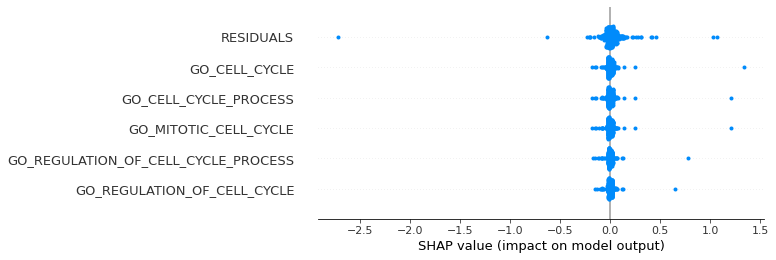

In [7]:
pathway_names = ["c2.cp.kegg.v7.1", "c2.cp.reactome.v7.0", "h.all.v7.1", "c5.bp.v7.0"]
for pathway_name in pathway_names:
    plt.clf()
    gs_path  = "data/pathways/"
    gs_fname = [f for f in os.listdir(gs_path) if pathway_name in f][0]
    tags, urls, genes = load_gene_set(gs_path+gs_fname)

    beta = get_beta(genes, X_train)
    pathway_attr, set_names = get_pathway_attr(tags, tree_attr, beta, outcome_name, 
                                               pathway_name, max_size = None)

    beta_norm = beta.T/beta.sum(1)
    X_test_pathway = X_test @ beta_norm # (# samples, # pathways)
    shap.summary_plot(pathway_attr.mean(2), show=False, feature_names=set_names, max_display=6)
    plt.savefig("fig/{}_pathway_{}_importance.pdf".format(outcome_name,"".join(pathway_name.split("."))))

#### Kegg
* Ubiquitin and breast cancer, Oncogene March 2004

#### Biological Processes

### Get pathway sizes ordered by the mean absolute attribution

In [ ]:
ordered_pathways = []
for i in np.argsort(-np.abs(pathway_attr.mean(2)).mean(0)):
    ordered_pathways += [set_names[i]]

ordered_sizes = beta.sum(1)[np.argsort(-np.abs(pathway_attr.mean(2)).mean(0))]

import matplotlib.pyplot as plt
plt.plot(ordered_sizes[1:])
plt.title("Bias of pathway size")
plt.ylabel("Group size")
plt.xlabel("Pathway rank")
plt.show()

Everything is zero except for cytokine and residual

In [ ]:
np.abs(pathway_attr.mean(2)).mean(0)